<h1 style="text-align:center;"><em>Project 1. Handwriting recognition with neural network</em></h1>

In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128
epochs = 20
lr = 1e-3
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

OUT_DIR = Path('results'); OUT_DIR.mkdir(parents=True, exist_ok=True)

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])
train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
val_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# imgs, targets =train_ds[0]
# imgs.size()
# imgs.min(), imgs.max()

***Linear Model***

In [2]:
class LinearModel(nn.Module):

    def __init__(self, input_size = 28*28, nb_classes=10):
        super().__init__()
        self.linear = nn.Linear(input_size, nb_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

***Multi-Layer Perceptron models (ShallowMLP and DeepMLP)***

In [3]:
class MLP(nn.Module):

    def __init__(self, input_size=28*28, h_layers= [512, 256], nb_classes=10, dropout = 0.1):
        super().__init__()
        modules = []
        h_layers = [input_size] + h_layers
        for h in range (len(h_layers)-1):
            modules.append(nn.Linear(h_layers[h], h_layers[h+1]))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(dropout))
        modules.append(nn.Linear(h_layers[-1], nb_classes))
        
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [4]:
# Training function
def train_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    correct =0.0
    n = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        y_preds = out.argmax(1)
        correct += (y_preds==y).sum().item()
        n += X.size(0)

    return total_loss/n, correct/n


In [5]:
# Evaluate model function
@torch.no_grad
def eval_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0; correct = 0; n = 0
    all_preds = []; all_labels = []

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        total_loss += loss.item() * X.size(0)
        preds = out.argmax(1)
        correct += (preds==y).sum().item()
        n += X.size(0)
        all_preds.append(preds.cpu().numpy()); all_labels.append(y.cpu().numpy())
        
    return total_loss/n, correct/n, np.concatenate(all_preds), np.concatenate(all_labels) # for cm and free GPU


### ***Model Comparison***

``Train Linear, ShalloMLP and DeepMLP models without L2 regularization using CrossEntropy
loss:``

In [8]:
models = {
    "linear": LinearModel().to(device),
    "shallowMLP": MLP(h_layers=[512]).to(device),
    "deepMLP": MLP(h_layers=[512, 256]).to(device)
}

In [9]:

# Training without L2 reg

loss_fn = CrossEntropyLoss()
compare_models = {}

for name, model in models.items():
    print(f"\nTraining {name} model\n")
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
    
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    val_losses = []
    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        v_loss, v_acc, _, _ = eval_model(model, val_loader, loss_fn, device)

        train_losses.append(t_loss); val_losses.append(v_loss)
        train_accuracy.append(t_acc); val_accuracy.append(v_acc)

        print(f"\tEpoch {epoch+1}/{epochs}: train_loss = {t_loss} | val_loss = {v_loss}")

    compare_models[name] = dict(train_losses=train_losses,
                                train_accuracy=train_accuracy,
                                val_losses=val_losses, 
                                val_accuracy=val_accuracy,
                            )


Training linear model

	Epoch 1/20: train_loss = 0.65869816142718 | val_loss = 0.37834458413124084
	Epoch 2/20: train_loss = 0.35901782660484316 | val_loss = 0.3193966242313385
	Epoch 3/20: train_loss = 0.3177896769444148 | val_loss = 0.2948245584487915
	Epoch 4/20: train_loss = 0.2984545100212097 | val_loss = 0.2843595221042633
	Epoch 5/20: train_loss = 0.28691325469017026 | val_loss = 0.27833505465984343
	Epoch 6/20: train_loss = 0.2791410458087921 | val_loss = 0.27350202136039736
	Epoch 7/20: train_loss = 0.2728911280155182 | val_loss = 0.2714997068524361
	Epoch 8/20: train_loss = 0.2685235065062841 | val_loss = 0.26935259813070295
	Epoch 9/20: train_loss = 0.26504498771826424 | val_loss = 0.2654493361115456
	Epoch 10/20: train_loss = 0.262100008837382 | val_loss = 0.2665917408227921
	Epoch 11/20: train_loss = 0.25932026964028676 | val_loss = 0.2667482427716255
	Epoch 12/20: train_loss = 0.25688835344314576 | val_loss = 0.2633588382601738
	Epoch 13/20: train_loss = 0.25517669411500

``Plot val loss vs. epochs for each model and compare how hidden layer size and depth
affect performance.``

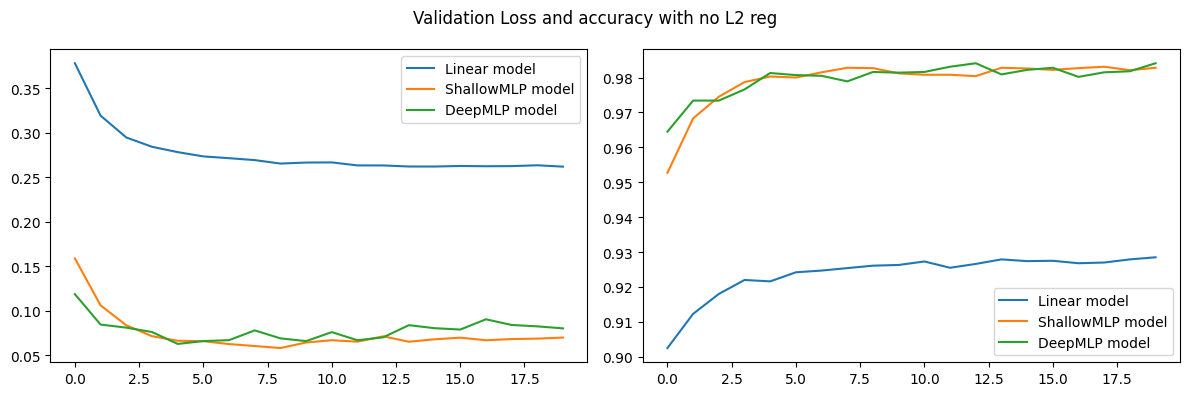

In [10]:

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Validation Loss and accuracy with no L2 reg')
# Val Loss
axes[0].plot(compare_models['linear']['val_losses'], label='Linear model')
axes[0].plot(compare_models['shallowMLP']['val_losses'], label='ShallowMLP model')
axes[0].plot(compare_models['deepMLP']['val_losses'], label='DeepMLP model')
axes[0].legend()
#Accu
axes[1].plot(compare_models['linear']['val_accuracy'], label='Linear model')
axes[1].plot(compare_models['shallowMLP']['val_accuracy'], label='ShallowMLP model')
axes[1].plot(compare_models['deepMLP']['val_accuracy'], label='DeepMLP model')
axes[1].legend()

plt.tight_layout()
plt.show()

#### ***Effect of L2 Reg***

``Training three Linear models with no regularization, low regularization, and high regularization and store weights``

In [11]:

loss_fn = CrossEntropyLoss()
compare_linear_per_reg_param = {}
weights = {}
l2_params = [0.0, 0.5, 2]

for reg_param in l2_params:
    print(f"\n Training Linear model L2  parameter = {reg_param}: ")

    y_preds_true_models = {}
    model = LinearModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_param)
    
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    val_losses = []
    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        v_loss, v_acc, _, _ = eval_model(model, val_loader, loss_fn, device)

        train_losses.append(t_loss); val_losses.append(v_loss)
        train_accuracy.append(t_acc); val_accuracy.append(v_acc)

        print(f"\t Epoch {epoch+1}/{epochs}: train_loss = {t_loss} | val_loss = {v_loss}")

    weights[reg_param] = model.linear.weight.data.cpu().numpy().copy()



 Training Linear model L2  parameter = 0.0: 
	 Epoch 1/20: train_loss = 0.6653463538487753 | val_loss = 0.38100479431152345
	 Epoch 2/20: train_loss = 0.3596747080246607 | val_loss = 0.31832460753917696
	 Epoch 3/20: train_loss = 0.3175212509870529 | val_loss = 0.2966893214225769
	 Epoch 4/20: train_loss = 0.29866234703063965 | val_loss = 0.2844133039951324
	 Epoch 5/20: train_loss = 0.28699995745023094 | val_loss = 0.27543512349128724
	 Epoch 6/20: train_loss = 0.2789201990604401 | val_loss = 0.27203565742969515
	 Epoch 7/20: train_loss = 0.273265557217598 | val_loss = 0.27084452488422395
	 Epoch 8/20: train_loss = 0.2687113799730937 | val_loss = 0.2679267660975456
	 Epoch 9/20: train_loss = 0.26494627209504445 | val_loss = 0.26813234298229216
	 Epoch 10/20: train_loss = 0.26147460363705954 | val_loss = 0.26514095560312273
	 Epoch 11/20: train_loss = 0.2594724976301193 | val_loss = 0.2648695236682892
	 Epoch 12/20: train_loss = 0.25750098152160644 | val_loss = 0.2647366966366768
	 Ep

``Visualize each model’s weights (rows reshaped as
28×28 images)``

/tmp/ipython-input-3401769663.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.80, 0.95])


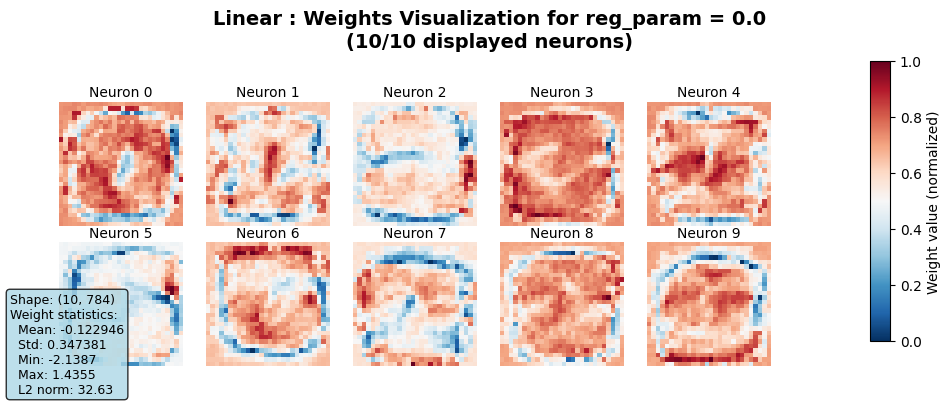

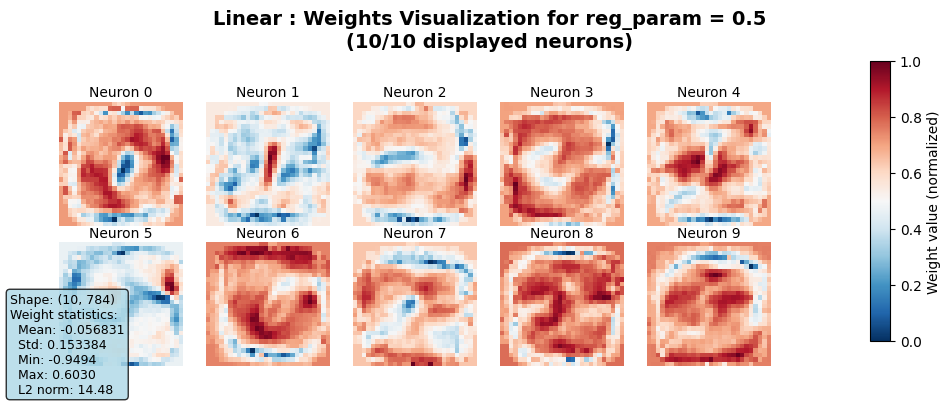

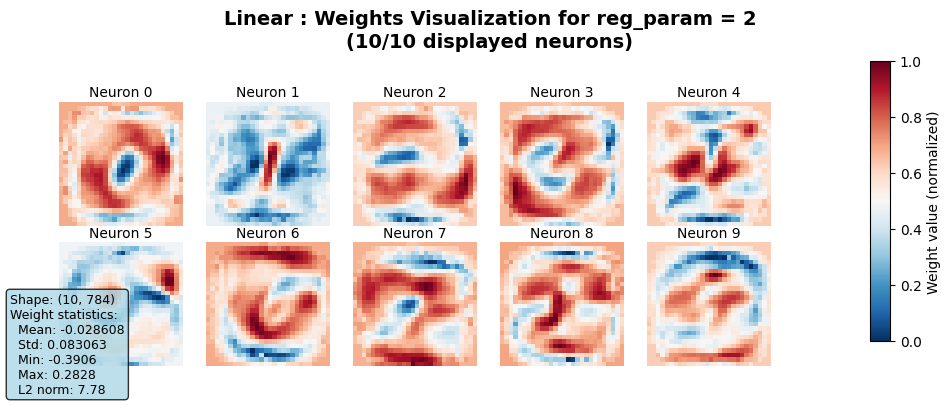

In [12]:

# Weights Visualization function
def visualize_model_weights(weights, reg_param, n_neurons_display=10):
       
    n_neurons, n_inputs = weights.shape
    reg_info = f"{reg_param}" if reg_param is not None else ""
    display_count = min(n_neurons_display, n_neurons)
    
    fig = plt.figure(figsize=(10, 4))
    
    # Title
    suptitle = f"Linear : Weights Visualization for reg_param = {reg_info}\n"
    suptitle += f"({display_count}/{n_neurons} displayed neurons)"
    plt.suptitle(suptitle, fontsize=14, fontweight='bold', y=0.98)


    n_cols = 5  
    n_rows = int(np.ceil(display_count / n_cols))
    
    # Display neurons
    for neuron_idx in range(display_count):
        ax = plt.subplot(n_rows, n_cols, neuron_idx + 1)
        
        # Reshape in 28×28
        neuron_weights = weights[neuron_idx].reshape(28, 28)
        
        # Normalization
        w_min = neuron_weights.min()
        w_max = neuron_weights.max()
        if w_max - w_min > 1e-8:
            neuron_weights_norm = (neuron_weights - w_min) / (w_max - w_min)
        else:
            neuron_weights_norm = np.zeros_like(neuron_weights)
        
        # display
        im = ax.imshow(neuron_weights_norm, cmap='RdBu_r', vmin=0, vmax=1)
        ax.set_title(f"Neuron {neuron_idx}", fontsize=10, pad=4)
        ax.axis('off')
    
    # Summary
    stats_text = (  f"Shape: {weights.shape}\n"
                    f"Weight statistics:\n"
                    f"  Mean: {weights.mean():.6f}\n"
                    f"  Std: {weights.std():.6f}\n"
                    f"  Min: {weights.min():.4f}\n"
                    f"  Max: {weights.max():.4f}\n"
                    f"  L2 norm: {np.sqrt((weights**2).sum()):.2f}")
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Weight value (normalized)')
    plt.tight_layout(rect=[0.05, 0.05, 0.80, 0.95])
    plt.show()

for reg_param, weigth in weights.items():
    print(f"\n{'='*60}")

    visualize_model_weights(
        weights=weigth,
        reg_param=reg_param
    )

#### ***Evaluation and Confusion Matrix:***

``Choose the best-performing MLP and predict on the
test set.``

In [23]:

def find_best_model(models_dict, reg_params=[0.0]):
    
    min_val_losses = {}
    min_losses = []
    best_model_name = ''
    for reg in reg_params:
        min_val_losses [reg] = {}
        for name, _ in models_dict.items():
            val_loss = min(models_dict[name]['val_losses'])
            min_val_losses[reg][val_loss] = name
            min_losses.append(val_loss)

    for key, value in min_val_losses.items():
        try:
            best_model_name = value[min(min_losses)]
        except:
            pass
    return best_model_name

best_model = find_best_model(compare_models)
best_model

'shallowMLP'

``Build and plot confusion matrix from scratch``

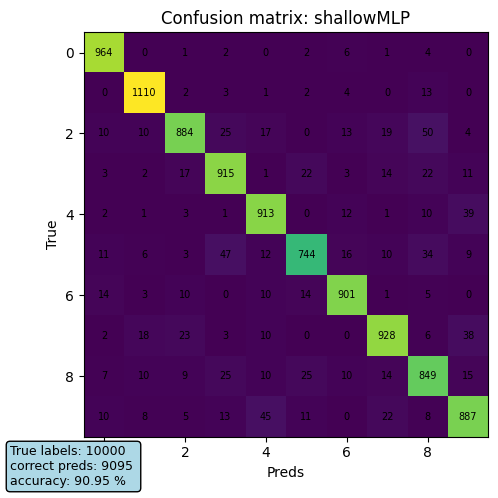

In [14]:
def confusion_matrix(y_true, y_preds, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t,p in zip(y_true, y_preds):
        cm[t,p] += 1
    return cm

def plot_confusion_matrix(y_true, y_preds):
    cm = confusion_matrix(y_true=y_true, y_preds=y_preds)
    plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='auto'); 
    plt.title(f'Confusion matrix: {best_model}'); plt.xlabel('Preds'); plt.ylabel('True')
    correct_preds = np.sum(np.diag(cm))
    accuracy = (correct_preds * 100 )/ y_true.shape[0]
    stats_text = (f"True labels: {y_true.shape[0]}\n"
                    f"correct preds: {correct_preds} \n"
                    f"accuracy: {accuracy} %"
                 )
            
    plt.figtext(0.04, 0.02, stats_text, fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=1))
    for i in range(10):
        for j in range(10):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=7)
    plt.tight_layout()
    plt.show()

_, accuracy, y_preds, y_true = eval_model(model, val_loader, loss_fn, device)
plot_confusion_matrix(y_true=y_true, y_preds=y_preds)

#### ***Regularization and Overfitting:***

``Retrain the chosen MLP with different L2 strengths``

In [18]:

# Training the choosen MLP model (best_model)

loss_fn = CrossEntropyLoss()
compare_model_per_reg_param = {}
l2_strengths = [0.0, 1e-3, 2]

for reg_param in l2_strengths:
    print(f"\n Training {best_model} model L2 parameter = {reg_param}: ")
    model = MLP(h_layers=[512]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_param)
    
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    val_losses = []
    for epoch in range(epochs):
        t_loss, t_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        v_loss, v_acc, _, _ = eval_model(model, val_loader, loss_fn, device)

        train_losses.append(t_loss); val_losses.append(v_loss)
        train_accuracy.append(t_acc); val_accuracy.append(v_acc)

        print(f"\tEpoch {epoch+1}/{epochs}: train_loss = {t_loss} | val_loss = {v_loss}")

    compare_model_per_reg_param[reg_param] = dict(train_losses=train_losses,
                                train_accuracy=train_accuracy,
                                val_losses=val_losses, 
                                val_accuracy=val_accuracy,
                            )
    # _, _, y_preds, y_true = eval_model(model, val_loader, loss_fn, device)


 Training shallowMLP model L2 parameter = 0.0: 


	Epoch 1/20: train_loss = 0.3222000814716021 | val_loss = 0.16077544174194336
	Epoch 2/20: train_loss = 0.13261100831429162 | val_loss = 0.10146319617778063
	Epoch 3/20: train_loss = 0.08961617226998012 | val_loss = 0.08147762922346592
	Epoch 4/20: train_loss = 0.06588761681566636 | val_loss = 0.06966678530927747
	Epoch 5/20: train_loss = 0.051574655173222225 | val_loss = 0.06628514465726912
	Epoch 6/20: train_loss = 0.040600706613063815 | val_loss = 0.0763923815049231
	Epoch 7/20: train_loss = 0.03288716447899739 | val_loss = 0.06252994108274579
	Epoch 8/20: train_loss = 0.02595894271383683 | val_loss = 0.06301820221142844
	Epoch 9/20: train_loss = 0.022006465807557107 | val_loss = 0.05867495756651042
	Epoch 10/20: train_loss = 0.01804290878251195 | val_loss = 0.06347244369564578
	Epoch 11/20: train_loss = 0.015243408369769652 | val_loss = 0.06603367555518634
	Epoch 12/20: train_loss = 0.012469116192186873 | val_loss = 0.07055714131575078
	Epoch 13/20: train_loss = 0.01161084342350562

``Plot
loss and accuracy (train vs. test) to observe overfitting and identify optimal regularization.``

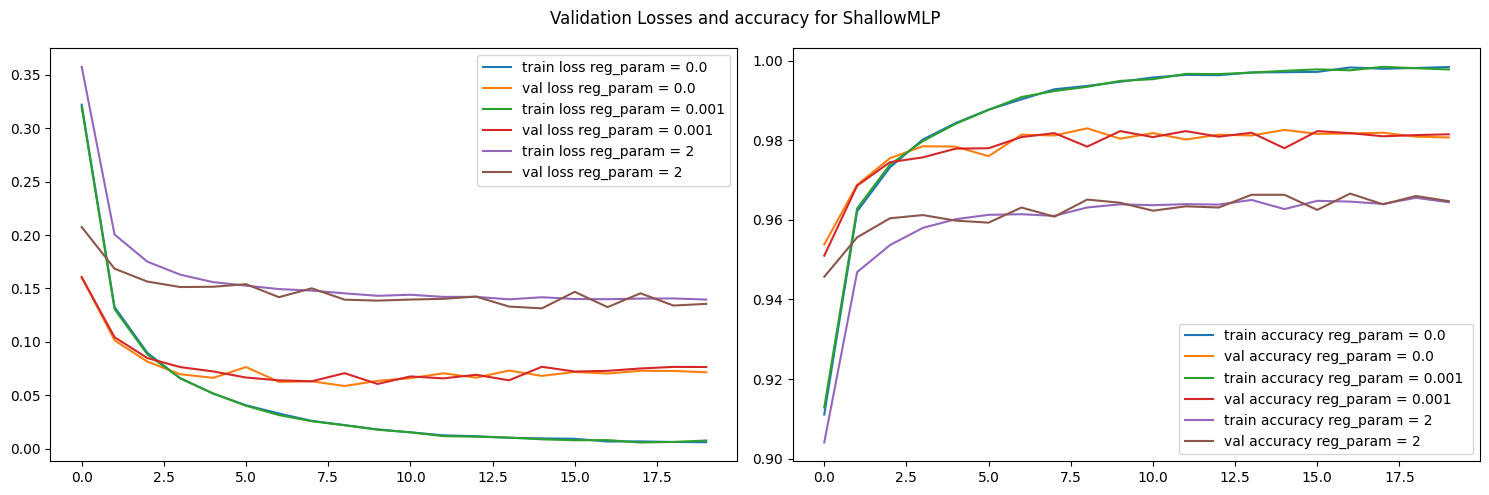

In [24]:

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Validation Losses and accuracy for ShallowMLP')

for reg_param in l2_strengths:
    # Train Loss
    axes[0].plot(compare_model_per_reg_param[reg_param]['train_losses'], label=f'train loss reg_param = {reg_param}')
    
    # Train Accu
    axes[1].plot(compare_model_per_reg_param[reg_param]['train_accuracy'], label=f'train accuracy reg_param = {reg_param} ')
    
    # Val Loss
    axes[0].plot(compare_model_per_reg_param[reg_param]['val_losses'], label=f'val loss reg_param = {reg_param}')
    axes[0].legend()
    
    # Val Accu
    axes[1].plot(compare_model_per_reg_param[reg_param]['val_accuracy'], label=f'val accuracy reg_param = {reg_param} ')
    axes[1].legend()
plt.tight_layout()
plt.show()

### ***Bonus:***

In [26]:

def eval_model_per_class(model, loader, loss_fn, device, num_classes=10):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    class_correct = torch.zeros(num_classes, device=device)
    class_total = torch.zeros(num_classes, device=device)

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item()

            preds = logits.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            for k in range(num_classes):
                mask = (y == k)
                class_correct[k] += (preds[mask] == y[mask]).sum()
                class_total[k] += mask.sum()

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    per_class_accuracy = (class_correct / class_total).cpu().numpy()

    return avg_loss, accuracy, per_class_accuracy


In [ ]:
loss_fn = CrossEntropyLoss()
model = MLP(h_layers=[512]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.003)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

per_class_accuracy = {k: [] for k in range(10)}

for epoch in range(epochs):
    t_loss, t_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    v_loss, v_acc, class_acc = eval_model_per_class(model, val_loader, loss_fn, device)
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accuracy.append(t_acc)
    val_accuracy.append(v_acc)

    for k in range(10):
        per_class_accuracy[k].append(class_acc[k])
        
    print(f"\tEpoch {epoch+1}/{epochs}: train_loss = {t_loss} | val_loss = {v_loss}")


Epoch 1/20 | train_loss=0.3215 | val_loss=0.1484 | val_acc=0.9566
Epoch 2/20 | train_loss=0.1334 | val_loss=0.1153 | val_acc=0.9655
Epoch 3/20 | train_loss=0.0893 | val_loss=0.0843 | val_acc=0.9730
Epoch 4/20 | train_loss=0.0668 | val_loss=0.0785 | val_acc=0.9750
Epoch 5/20 | train_loss=0.0504 | val_loss=0.0649 | val_acc=0.9802
Epoch 6/20 | train_loss=0.0408 | val_loss=0.0669 | val_acc=0.9796
Epoch 7/20 | train_loss=0.0326 | val_loss=0.0606 | val_acc=0.9812
Epoch 8/20 | train_loss=0.0261 | val_loss=0.0628 | val_acc=0.9794
Epoch 9/20 | train_loss=0.0232 | val_loss=0.0591 | val_acc=0.9814
Epoch 10/20 | train_loss=0.0190 | val_loss=0.0591 | val_acc=0.9828
Epoch 11/20 | train_loss=0.0149 | val_loss=0.0658 | val_acc=0.9803
Epoch 12/20 | train_loss=0.0124 | val_loss=0.0599 | val_acc=0.9829
Epoch 13/20 | train_loss=0.0115 | val_loss=0.0626 | val_acc=0.9829
Epoch 14/20 | train_loss=0.0097 | val_loss=0.0627 | val_acc=0.9811
Epoch 15/20 | train_loss=0.0094 | val_loss=0.0691 | val_acc=0.9815
Epoc

``Visualize how the model learns to recognize different digits throughout training.``

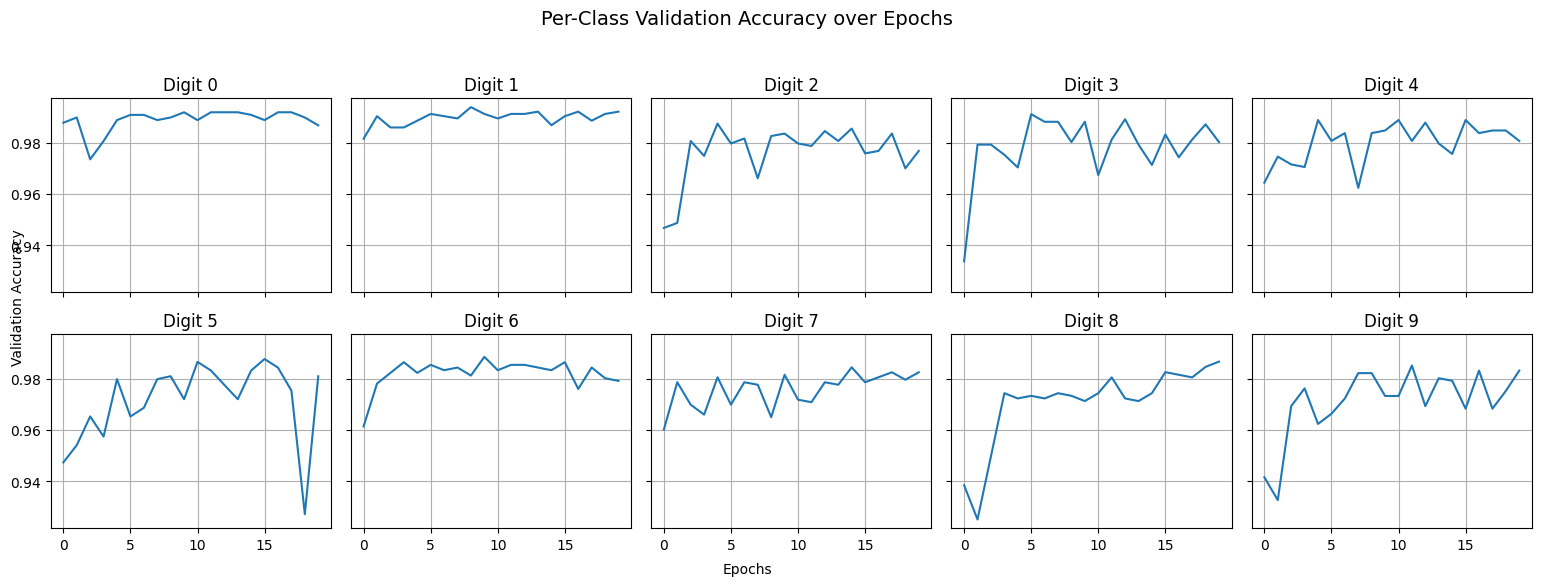

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=True)

axes = axes.flatten()

for digit in range(10):
    axes[digit].plot(
        per_class_accuracy[digit]
    )
    axes[digit].set_title(f"Digit {digit}")
    axes[digit].grid(True)

fig.suptitle("Per-Class Validation Accuracy over Epochs", fontsize=14)
fig.text(0.5, 0.04, "Epochs", ha="center")
fig.text(0.04, 0.5, "Validation Accuracy", va="center", rotation="vertical")

plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
plt.show()
